# Random Forests & Ensembles

Nesse notebook vamos estudar técnicas para combinar o resultado de múltiplos modelos de forma a construir preditores mais poderosos e mitigar alguns dos problemas que surgem nos métodos que já estudamos

In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import utils

In [3]:
np.random.seed(42)

# plt.rcParams['figure.figsize'] = (8.0, 5.0)

## Relembrando sobre Árvores de Decisão

In [4]:
x, y, target_names = utils.load_dataset('cancer')

print('instancias X features:', x.shape)

instancias X features: (569, 30)


In [5]:
x.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=100, random_state=42)

In [7]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', max_depth=4)
dt.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [8]:
from sklearn.metrics import accuracy_score

ytrain_pred = dt.predict(xtrain)
ytest_pred = dt.predict(xtest)

print('Acurácia no treino:', accuracy_score(ytrain, ytrain_pred))
print('Acurácia no teste:', accuracy_score(ytest, ytest_pred))

Acurácia no treino: 0.9914712153518124
Acurácia no teste: 0.95


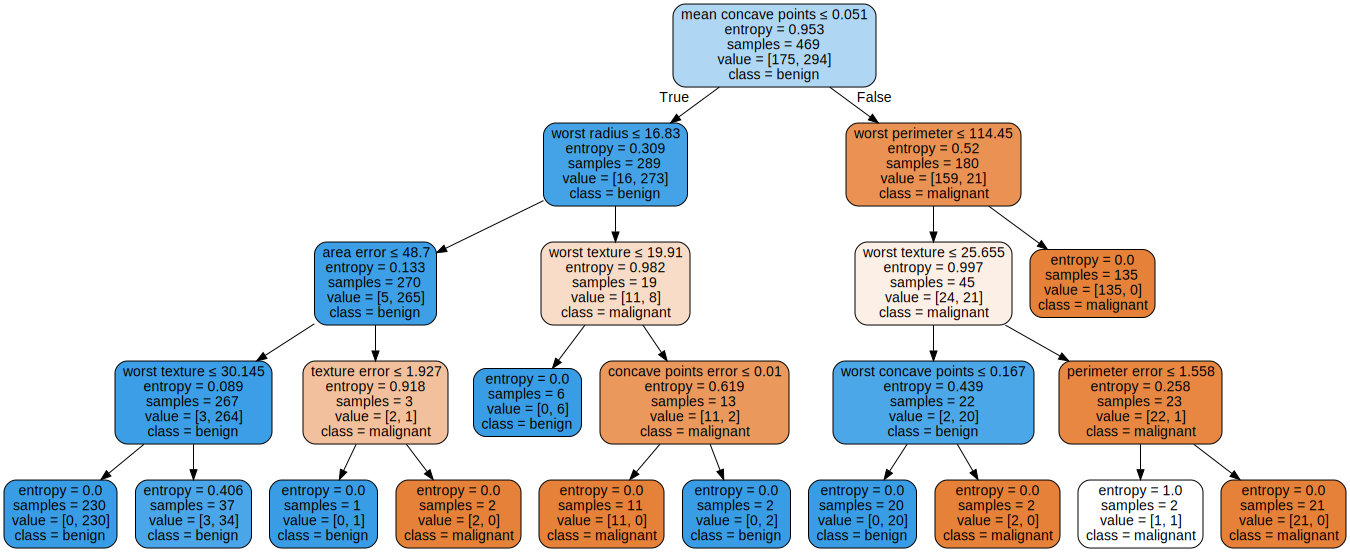

In [9]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dt,
                           out_file=None,
                           feature_names=x.columns,
                           class_names=target_names,
                           filled=True, 
                           rounded=True, 
                           special_characters=True)
graphviz.Source(dot_data)

Obtivemos uma acurácia no teste de 94%, o que parece bem razoável. Vamos tentar de novo, mas vamos tirar o `random_state=42` do nosso `train_test_split`, o que vai fazer com que os nossos 150 exemplos de teste (e consequentemente os nossos exemplos de treino) sejam sempre diferentes:

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=150)

dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(xtrain, ytrain)

accuracy_score(ytest, dt.predict(xtest))

0.92

Vamos criar um loop para poder fazer isso várias vezes

In [11]:
for i in range(20):
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=150)

    dt = DecisionTreeClassifier(criterion='entropy')
    dt.fit(xtrain, ytrain)

    print(accuracy_score(ytest, dt.predict(xtest)))

0.92
0.92
0.9533333333333334
0.9266666666666666
0.9666666666666667
0.92
0.94
0.94
0.92
0.92
0.9066666666666666
0.9333333333333333
0.9066666666666666
0.92
0.9266666666666666
0.9533333333333334
0.9133333333333333
0.9333333333333333
0.9066666666666666
0.9266666666666666


Vemos que o desempenho do nosso classificador **varia muito**, o que não é ideal, pois isso representa instabilidade e não 
nos dá confiança que o desempenho dele será exatamente esse quando ele estiver tomando decisões reais em produção.

## Fronteiras de Decisão

Podemos visualizar as fronteiras de decisão de cada classificador treinado para entender melhor de onde vem essa instabilidade os erros que eles cometem:

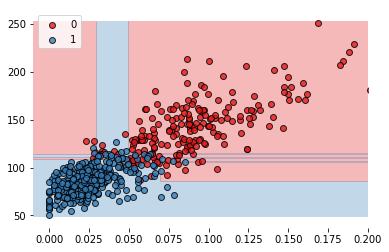

In [12]:
sx = x[['mean concave points', 'worst perimeter']]

xtrain, xtest, ytrain, ytest = train_test_split(sx, y, test_size=150)

dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
    
utils.plot2d(sx.values, y.values, clf=dt)
plt.xlim((-0.01, 0.20))
plt.legend(loc=0)

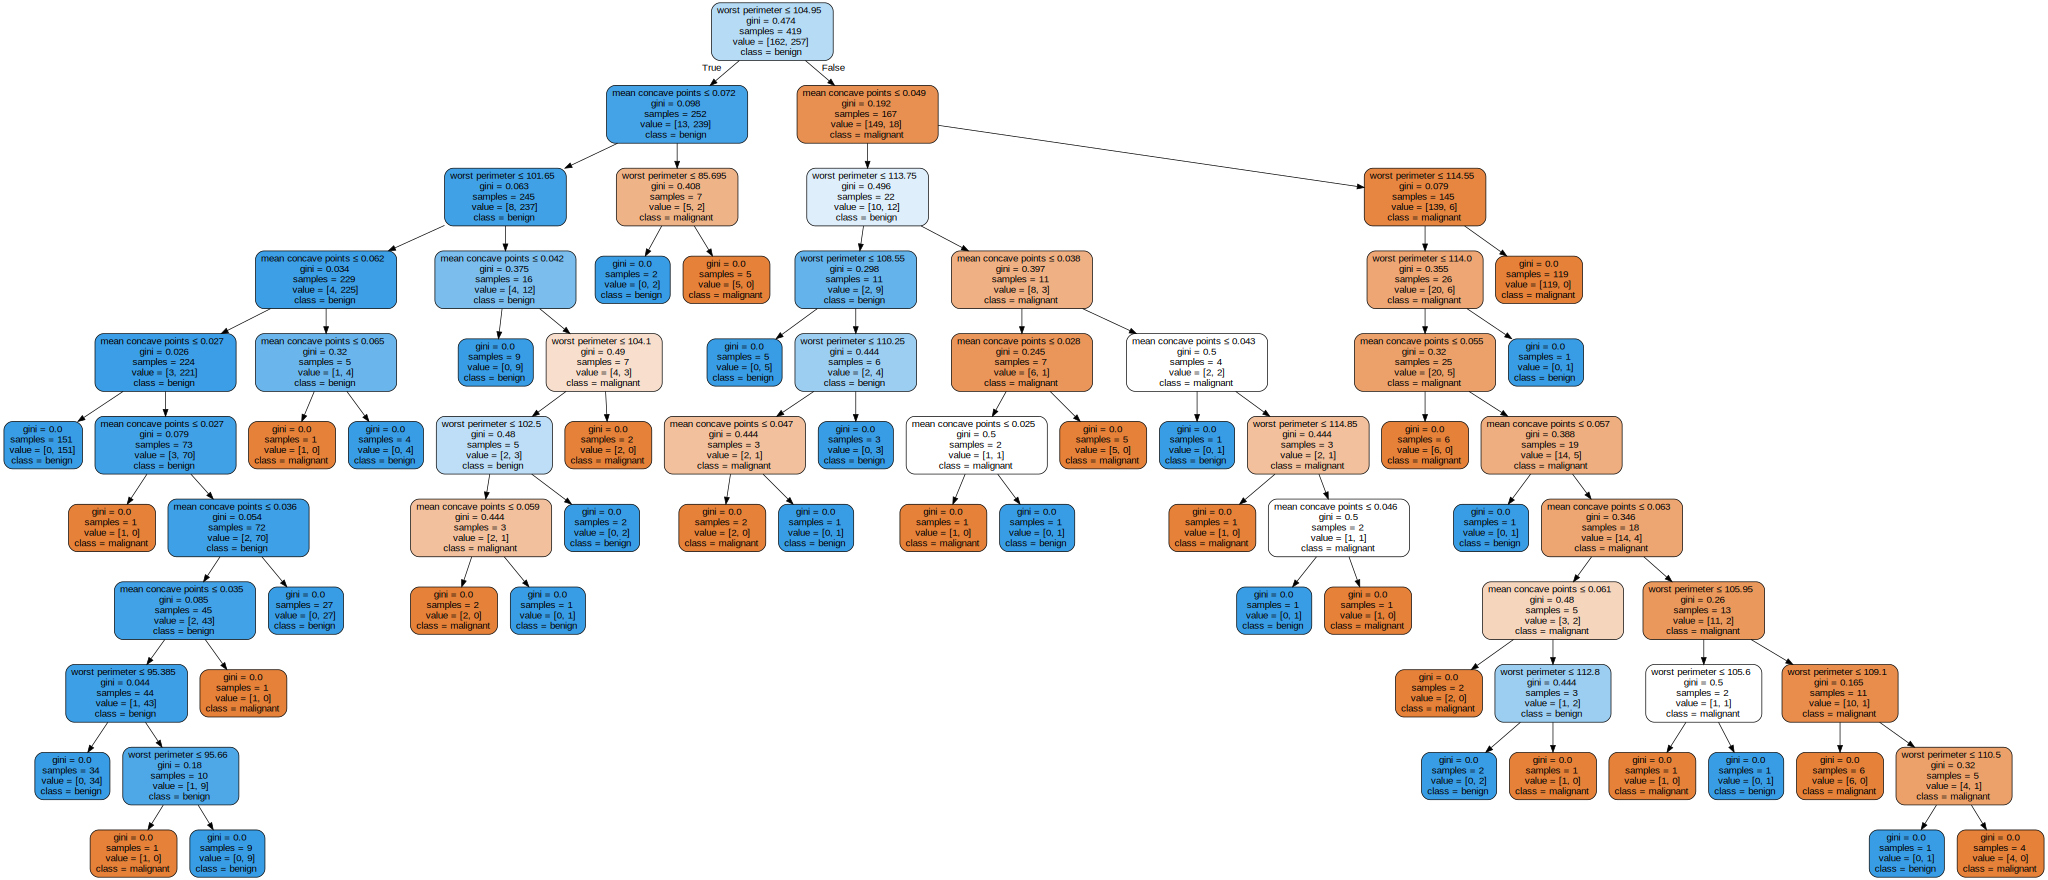

In [14]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dt,
                           out_file=None,
                           feature_names=xtrain.columns,
                           class_names=target_names,
                           filled=True, rounded=True, 
                           special_characters=True)
graphviz.Source(dot_data)

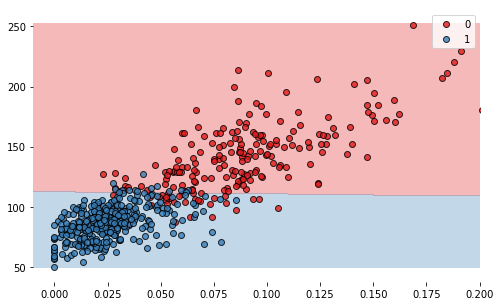

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(xtrain, ytrain)

utils.plot2d(sx.values, y.values, clf=lr)
plt.xlim((-0.01, 0.20))
plt.legend(loc=0)

## Combining (ensembling)

Temos vários classificadores treinados com árvores de decisão. Cada um deles é enviesado de uma forma diferente. Por que não combinar a opinião de todos eles?

<img src='img/1_C7CrBG1VNaa1x491eZ3fnw.gif'>
<img src='img/bagging_example.png'>

In [16]:
def sample(x, y, f):
    sx = x.sample(frac=f)
    sy = y.loc[sx.index]
    return sx, sy

In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=100)

accs = []
predictions = []
for r in range(50):
    
    sx, sy = sample(xtrain, ytrain, 0.5)
    dt = DecisionTreeClassifier()
    dt.fit(sx, sy)

    yp = dt.predict(xtest)
    
    accs.append(accuracy_score(ytest, yp))
    predictions.append(yp)


predictions = np.array(predictions)

In [18]:
predictions

array([[1, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 1, 1],
       ...,
       [1, 1, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 1, 1]])

In [19]:
yp_ensemble = np.mean(predictions, axis=0)>0.5    # Aqui acontece a votação por maioria, que é feita verificando que a média de 1's em cada coluna é maior que 0.5
yp_ensemble

array([ True, False, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False, False,  True, False, False,
        True, False, False,  True,  True, False,  True,  True,  True,
       False,  True, False,  True, False,  True,  True,  True, False,
        True,  True,  True,  True, False, False, False, False, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True, False, False,  True,  True,  True, False,  True, False,
        True, False,  True,  True, False,  True, False,  True,  True,
        True,  True, False,  True,  True, False,  True, False,  True,
       False])

In [20]:
print('Acurácia média dos classificadores individuais:', np.mean(accs))
print('Acurácia da opinião da maioria dos classificadores:', accuracy_score(ytest, yp_ensemble))

Acurácia média dos classificadores individuais: 0.9166
Acurácia da opinião da maioria dos classificadores: 0.97


A técnica que acabamos de usar é um tipo de **ensembling**, mais especificamente um tipo de **bagging**. Nessa aula vamos aprender outras estratégias e formas mais fáceis de implementá-las.

## Random Forest

É muito simples utilizar random forest no nosso dataset:

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5, n_estimators=20, max_features=0.5)
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
# import shap

# shap_values = shap.TreeExplainer(rf).shap_values(xtest)
# shap.summary_plot(shap_values, xtest)

In [24]:
ypred = rf.predict(xtest)
accuracy_score(ytest, ypred)

0.95

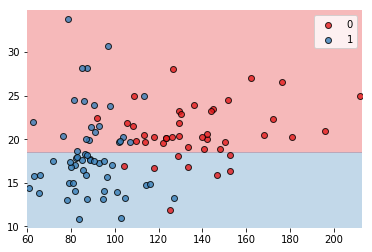

In [28]:
minidf = xtrain[['worst perimeter', 'mean texture']]
rf = RandomForestClassifier(max_depth=1, n_estimators=1, max_features=0.5)
rf.fit(minidf, ytrain)

utils.plot2d(minidf.head(100).values, ytrain.head(100).values, clf=rf)
# plt.xlim((-0.05, 0.15))
# plt.ylim((0, 0.20))
plt.legend(loc=0)

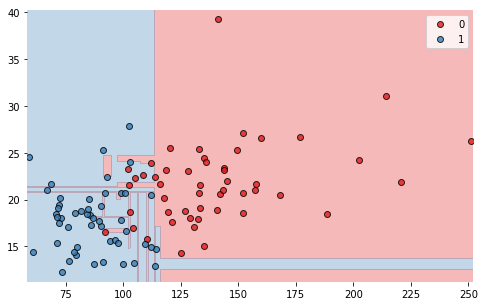

In [36]:
minidf = xtrain[['worst perimeter', 'mean texture']]
rf = RandomForestClassifier(max_depth=30, n_estimators=1, max_features=0.5)
rf.fit(minidf, ytrain)

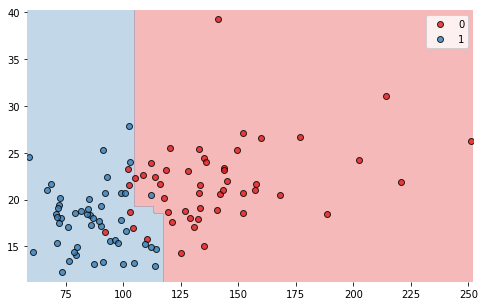

In [38]:
minidf = xtrain[['worst perimeter', 'mean texture']]
rf = RandomForestClassifier(max_depth=2, n_estimators=20, max_features=0.5)
rf.fit(minidf, ytrain)

utils.plot2d(minidf.head(100).values, ytrain.head(100).values, clf=rf)
plt.legend(loc=0)

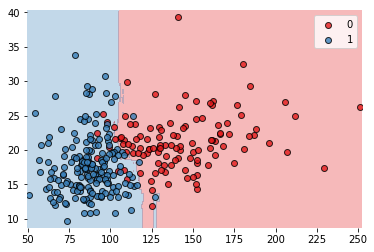

In [30]:
minidf = xtrain[['worst perimeter', 'mean texture']]
rf = RandomForestClassifier(max_depth=5, n_estimators=100, max_features=0.5)
rf.fit(minidf, ytrain)

utils.plot2d(minidf.head(300).values, ytrain.head(300).values, clf=rf)
plt.legend(loc=0)

# Ele está pegando a curva média de várias curvas simples!
<img src='img/skitch.png'>

## Exercício: Inadimplência

Nesse exemplo vamos carregar um dataset novo. Cada exemplo é uma pessoa que pediu uma linha de crédito e devemos decidir a probabilidade dessa pessoa nos pagar de volta, ou não. Algumas coisas que vocês devem fazer:

* Liste os atributos do problema.
* Observe se algum atributo é categório (não numérico).
* Observe se algum atributo tem dados faltantes (nulls e nans).
* Observe se o problema é balanceado (o que é isso mesmo?).
* Separe um conjunto de teste e um de treino (quanto pra cada?)
* Treine uma árvore de decisão, uma regressão logística e uma floresta aleatória.
* Use o parâmetro `n_estimators` de `RandomForestClassifier` para ver como isso impacto do desempenho do seu modelo.
* Plote um gráfico `n_estimators` x `AUC` para sua random forest.
* A partir de qual valor de `n_estimators` você acha que não vale mais a pena aumentar?

In [38]:
from sklearn.metrics import roc_auc_score

def eval_auc(clf, x, y):
    ypred = clf.predict_proba(x)[:,1]
    return roc_auc_score(y, ypred)

# Dataset de deafult
df = pd.read_csv('./data/default.csv')
x = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

In [39]:
x.dtypes

RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

In [40]:
x.isnull().mean()

RevolvingUtilizationOfUnsecuredLines    0.0
age                                     0.0
NumberOfTime30-59DaysPastDueNotWorse    0.0
DebtRatio                               0.0
MonthlyIncome                           0.0
NumberOfOpenCreditLinesAndLoans         0.0
NumberOfTimes90DaysLate                 0.0
NumberRealEstateLoansOrLines            0.0
NumberOfTime60-89DaysPastDueNotWorse    0.0
NumberOfDependents                      0.0
dtype: float64

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

# Treine os seguintes modelos:

Nesse exercicio vamos usar o dataset de default para empréstimos:

https://www.kaggle.com/c/GiveMeSomeCredit/data
(os dados já estão na pasta data)

Nosso objetivo é calcular a probabilidade de alguém dar calote no banco.

Para isso, vamos treinar alguns modelos:

- um LogisticRegression
- um DecisionTreeCLassifier com max_depth = 20
- um RandomForestClassifier n_estimators = 10 e compare as métricas.

Agora vamos rodar diferentes RF passando n_estimators de 1 a 10 e plote a métrica vs n_estimators, interprete.




In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [43]:
from sklearn.model_selection import cross_val_score

In [68]:
cross_val_score(estimator=LogisticRegression(), X=x, y=y, cv=4,scoring='roc_auc').mean()

0.6954169823595652

In [58]:
cross_val_score(estimator=DecisionTreeClassifier(max_depth=20),
                X=x,
                y=y,
                scoring='roc_auc',
                cv=4).mean()

0.6002088514897737

In [60]:
cross_val_score(estimator=RandomForestClassifier(max_depth=10,
                                                 n_estimators=10),
               X=x,
               y=y,
               scoring='roc_auc',
               cv=4).mean()

0.8602047176742439

In [61]:
metricas=[]
for i in range(1,11):
    metricas.append([i,cross_val_score(estimator=RandomForestClassifier(max_depth=10,
                                                 n_estimators=i),
               X=x,
               y=y,
               scoring='roc_auc',
               cv=4).mean()])

In [63]:
df = pd.DataFrame(metricas,columns=['estimador','auc'])

In [65]:
df.set_index('estimador', inplace=True)

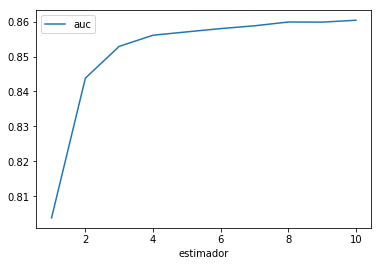

In [66]:
df.plot()

## Bagging


<img src='img/0_GHYCJIjkkrP5ZgPh.png'>

Nesse exercício vamos experimentar usar a `BaggingClassifier` do sklearn para criar ensembles com regressão logística e árvores de decisão.

In [69]:
from sklearn.ensemble import BaggingClassifier

In [70]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

In [71]:
BaggingClassifier()

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [72]:
from sklearn.metrics import roc_auc_score

n_estimators = [1,2,3,4,5,10,15,20]
dt_bag_scores = []   
lr_bag_scores = []
for ne in n_estimators:
    dt = DecisionTreeClassifier(max_depth=15, random_state=1)
    lr = LogisticRegression(random_state=1)
    
    dt_bag = BaggingClassifier(dt, n_estimators=ne)
    lr_bag = BaggingClassifier(lr, n_estimators=ne)

    dt_bag.fit(xtrain, ytrain)
    lr_bag.fit(xtrain, ytrain)

    dt_bag_scores.append(eval_auc(dt_bag, xtest, ytest))
    lr_bag_scores.append(eval_auc(lr_bag, xtest, ytest))

    print(ne,
          round(dt_bag_scores[-1],3),
          round(lr_bag_scores[-1],3))

1 0.669 0.701
2 0.749 0.703
3 0.803 0.703
4 0.818 0.704
5 0.83 0.702
10 0.847 0.704
15 0.848 0.704
20 0.85 0.703


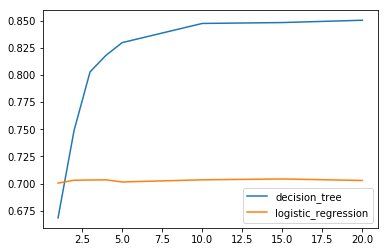

In [73]:
plt.plot(n_estimators, dt_bag_scores, label='decision_tree')
plt.plot(n_estimators, lr_bag_scores, label='logistic_regression')
plt.legend()

Vemos que o desempenho melhora consideravelmente ao combinar múltiplas árvores de decisão, ao contrário de regressões logísticas. Isso acontece por que todos os modelos de regressão logística combinados provavvelmente são muito parecidos, logo combiná-los não trás benefícios. Enquanto as árvores são consideravelmente diferentes, devido ao "problema" de variância que elas possuem.

Esse resultado talvez deixe claro por que *random forests* são tão populares e *random logistic regressions* não :)